# Временные ряды

### 1. Задание

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### 2. Импорт и подготовка данных

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import ast

In [117]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('datasets/taxi.csv')

data.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [118]:
#Датасет простой, но посмотреть не помешает
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [119]:
#Преобразуем столбец datetime в формат datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [120]:
#Сделаем столбец индексом
data.set_index('datetime', inplace = True)

In [121]:
#Упорядочим по датам
data = data.sort_index(ascending = True)
print(data.index.is_monotonic_increasing)

True


In [122]:
print('Данные находятся в периоде с ', str(data.index.min()), ' по ', str(data.index.max()))

Данные находятся в периоде с  2018-03-01 00:00:00  по  2018-08-31 23:50:00


In [123]:
#Сформируем графики среднего и суммарного количества заказов понедельно
#plt.figure(figsize=(8,5))
#plt.subplot(121)
#data.resample('1w').mean().plot(ax=plt.gca())
#plt.title('Среднее количество за неделю',fontsize=10, ha='center')
#plt.subplot(122)
#data.resample('1w').sum().plot(ax=plt.gca())
#plt.title('Сумма за неделю' ,fontsize=10, ha='center')

In [124]:
#Сделам ресемплирование по часу и по дням, для исследования сезонностей
data = data.resample('1h').sum()
data_week = data.resample('1d').sum()

In [125]:
decomposed = seasonal_decompose(data)
decomposed_week = seasonal_decompose(data_week)

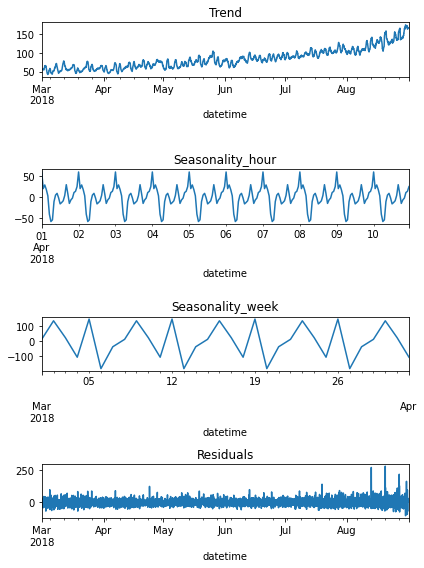

In [136]:
plt.figure(figsize=(6, 8))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(412)
decomposed.seasonal['2018-04-01':'2018-04-10'].plot(ax=plt.gca())
plt.title('Seasonality_hour')

plt.subplot(413)
decomposed_week.seasonal['2018-01-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality_week')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Вывод: существует суточная и недельная сезонность, причем, что удивительно для такси, колебания идеальные

### 3. Прогнозирование данных

In [127]:
def make_features(d, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    d['dayofweek'] = d.index.dayofweek
    d['hour'] = d.index.hour

    for lag in range(1, max_lag + 1):
        d['lag_{}'.format(lag)] = d['num_orders'].shift(lag)
        d['rolling_mean'] = d['num_orders'].shift().rolling(rolling_mean_size).mean()
    return d   

In [129]:
def grid_search(param, t,v):
    X_train, y_train = t.drop('num_orders', axis=1), t['num_orders']
    X_valid, y_valid = v.drop('num_orders', axis=1), v['num_orders']
    tscv = TimeSeriesSplit(n_splits=5)
    GridModel = GridSearchCV(estimator=param['model'], param_grid=param['params'], cv=tscv, scoring='neg_mean_squared_error', verbose=0)
    GridModel.fit(X_train, y_train)
    
    #Проверим на валидационной выборке
    model = param['model']
    model.set_params(**GridModel.best_params_)
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, pred)**0.5
    
    return score, GridModel.best_params_

In [130]:
#Функция поиска по таблицам с разными max_lag, rolling_mean_size 
def models_search(param, d1, table, num):
    n = len(d1)
    for i in range(len(param)):
        best_score = 1000
        best_model = ""
        tr, test = train_test_split(table, shuffle=False, test_size=0.1, random_state = 42)
        
        #В задании сказано, что тестовая 10%, поэтому, чтобы не нарушать условия, для valid выбрал 20% тестовой 
        train, valid = train_test_split(tr, shuffle=False, test_size=0.2, random_state = 42)
        
        train = train.dropna()
        test = test.dropna()
        valid = valid.dropna()
        
        score, best_p = grid_search(param[i], train, valid)
                
        d1.loc[i+n, 'model'] = param[i]['name']
        d1.loc[i+n, 'score_valid'] = score
        d1.loc[i+n, 'params'] = str(best_p)
        d1.loc[i+n, 'table'] = num

In [131]:

#RandomForestRegressor()
p1 = {'model':RandomForestRegressor(),
      'name': 'RandomForestRegressor',
      'params': {'n_estimators': [10, 20, 50, 100],  
                 'max_features': ['sqrt'],
                 'random_state': [42]}}


#Lasso()
p2 = {'model': Lasso(),
      'name': 'Lasso',
      'params': {'alpha': [0.1, 1.5, 10, 20, 100, 300]}}


#AdaBoostRegressor()
p3 = {'model':AdaBoostRegressor(),
      'name': 'AdaBoostRegressor',
      'params':{'learning_rate': [0.01, 0.1, 0.3, 0.8, 1],
                         'loss': ['linear', 'square', 'exponential']}}


param = [p1, p2, p3]


In [132]:
#Сформирум 2 таблицы с данными с разными max_lag, rolling_mean_size
s = data.copy()
s = make_features(s, 24, 168)
data = make_features(data, 48, 336)

#Проверим, что все корректно сформировалось, и таблицы разные
print(data.shape)
print(s.shape)

(4416, 52)
(4416, 28)


In [133]:
d1 = pd.DataFrame()
models_search(param, d1, s, 1)
models_search(param, d1, data, 2)


In [134]:
d1

,model,score_valid,params,table
0,RandomForestRegressor,32.507446,"{'max_features': 'sqrt', 'n_estimators': 100, ...",1.0
1,Lasso,33.026531,{'alpha': 1.5},1.0
2,AdaBoostRegressor,33.620640,"{'learning_rate': 1, 'loss': 'linear'}",1.0
3,RandomForestRegressor,32.846661,"{'max_features': 'sqrt', 'n_estimators': 100, ...",2.0
4,Lasso,30.399213,{'alpha': 10},2.0
5,AdaBoostRegressor,32.386924,"{'learning_rate': 1, 'loss': 'linear'}",2.0


Вывод: лучшая модель на train - Lasso с параметрами "{'alpha': 10}" на таблице с max_lag=48, rolling_mean_size = 336

In [135]:
tr, test = train_test_split(data, shuffle=False, test_size=0.1, random_state = 42)       
train, valid = train_test_split(tr, shuffle=False, test_size=0.2, random_state = 42)        
train = train.dropna()
test = test.dropna()
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']
model = Lasso()
model.set_params(**ast.literal_eval(d1['params'][4]))
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse_test = mean_squared_error(y_test, pred)**0.5
print('RMSE на тестовой выборке', rmse_test)

RMSE на тестовой выборке 42.647966575516435


Выводы: 
1. Есть резервы к улучшению  - увеличение max_lag, rolling_mean_size в таблице с данными
2. Лучшая модель Lasso с параметрами "{'alpha': 10}". Хорошие результаты модели достигаются на данных с большим  max_lag, rolling_mean_size. 
3. По условиям задачи RMSE на тестовой выборке должен быть не более 48, в данном случае, он достигается